In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 0)

import sys
sys.path.append('../')

import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm
tqdm.pandas()

from utils import generate_submit

In [1]:
NAME = 'v2'

In [10]:
train = pd.read_feather('../data/input/application_train.ftr')
test = pd.read_feather('../data/input/application_test.ftr')
bureau = pd.read_feather('../data/input/bureau.ftr')
pos = pd.read_feather('../data/input/pos_cash_balance.ftr')
previous = pd.read_feather('../data/input/previous_application.ftr')
card = pd.read_feather('../data/input/credit_card_balance.ftr')
submit = pd.read_feather('../data/input/sample_submission.ftr')

In [11]:
# handle binary and missing
# https://www.kaggle.com/c/home-credit-default-risk/discussion/57248
dfs = [train, test,bureau, pos, previous, card]
for df in tqdm(dfs):
    df.replace({'Y': 1, 'N': 0, 'M': 0, 'F': 1, 'XNA': np.nan, 'XAP': np.nan, 365243: np.nan}, inplace=True)

100%|██████████| 6/6 [02:13<00:00, 22.31s/it]


In [12]:
# null counts
train['main_null_cnt'] = train.isnull().sum(axis=1)
test['main_null_cnt'] = test.isnull().sum(axis=1)
bureau['bureau_null_cnt'] = bureau.isnull().sum(axis=1)
pos['pos_null_cnt'] = pos.isnull().sum(axis=1)
previous['previous_null_cnt'] = previous.isnull().sum(axis=1)
card['card_null_cnt'] = card.isnull().sum(axis=1)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
train['before_employ'] = train.DAYS_EMPLOYED - train.DAYS_BIRTH
test['before_employ'] = test.DAYS_EMPLOYED - test.DAYS_BIRTH

train['before_register'] = train.DAYS_REGISTRATION - train.DAYS_EMPLOYED
test['before_register'] = test.DAYS_REGISTRATION - test.DAYS_EMPLOYED

train['before_id_publish'] = train.DAYS_ID_PUBLISH - train.DAYS_REGISTRATION
test['before_id_publish'] = test.DAYS_ID_PUBLISH - test.DAYS_REGISTRATION

In [16]:
train['credit_income_ratio'] = train.AMT_CREDIT / train.AMT_INCOME_TOTAL
train['goods_income_ratio'] = train.AMT_CREDIT / train.AMT_INCOME_TOTAL
train['annuity_income_ratio'] = train.AMT_ANNUITY / train.AMT_INCOME_TOTAL
train['goods_credit_ratio'] = train.AMT_GOODS_PRICE / train.AMT_CREDIT
train['n_division'] = train.AMT_CREDIT / train.AMT_ANNUITY

test['credit_income_ratio'] = test.AMT_CREDIT / test.AMT_INCOME_TOTAL
test['goods_income_ratio'] = test.AMT_CREDIT / test.AMT_INCOME_TOTAL
test['annuity_income_ratio'] = test.AMT_ANNUITY / test.AMT_INCOME_TOTAL
test['goods_credit_ratio'] = test.AMT_GOODS_PRICE / test.AMT_CREDIT
test['n_division'] = test.AMT_CREDIT / test.AMT_ANNUITY

In [14]:
# https://www.kaggle.com/yekenot/catboostarter
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos.NAME_CONTRACT_STATUS.astype(str))
nunique_status = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status = nunique_status.NAME_CONTRACT_STATUS.reset_index().rename(columns={'NAME_CONTRACT_STATUS': 'pos_status_nunique'})
pos = pos.merge(nunique_status, on='SK_ID_CURR', how='left')
pos.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

card['NAME_CONTRACT_STATUS'] = le.fit_transform(card.NAME_CONTRACT_STATUS.astype(str))
nunique_status = card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status = nunique_status.NAME_CONTRACT_STATUS.reset_index().rename(columns={'NAME_CONTRACT_STATUS': 'card_status_nunique'})
card = card.merge(nunique_status, on='SK_ID_CURR', how='left')
card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

bureau_cat = [f for f in bureau.columns if bureau[f].dtype == 'object']
for f in tqdm(bureau_cat):
    bureau[f] = le.fit_transform(bureau[f].astype(str))
    nunique = bureau[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    nunique = nunique[f].reset_index().rename(columns={f: 'nunique_'+f})
    bureau = bureau.merge(nunique, on='SK_ID_CURR', how='left')
    bureau.drop(f, axis=1, inplace=True)
bureau.drop('SK_ID_BUREAU', axis=1, inplace=True)

previous_cat = [f for f in previous.columns if previous[f].dtype == 'object']
for f in tqdm(previous_cat):
    previous[f] = le.fit_transform(previous[f].astype(str))
    nunique = previous[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
    nunique = nunique[f].reset_index().rename(columns={f: 'nunique_'+f})
    previous = previous.merge(nunique, on='SK_ID_CURR', how='left')
    previous.drop(f, axis=1, inplace=True)
previous.drop('SK_ID_PREV', axis=1, inplace=True)

100%|██████████| 15/15 [03:26<00:00, 13.77s/it]


## Merge

In [34]:
print('pos cash')
avg_pos = pos.groupby('SK_ID_CURR').mean()
avg_pos['pos_count'] = pos.groupby('SK_ID_CURR').pos_null_cnt.count()
avg_pos.reset_index(inplace=True)

print('card')
avg_card = card.groupby('SK_ID_CURR').mean()
avg_card['card_count'] = card.groupby('SK_ID_CURR').card_null_cnt.count()
avg_card.reset_index(inplace=True)

print('bureau')
avg_bureau = bureau.groupby('SK_ID_CURR').mean()
avg_bureau['bureau_count'] = bureau.groupby('SK_ID_CURR').bureau_null_cnt.count()
avg_bureau.reset_index(inplace=True)

print('prev')
avg_previous = previous.groupby('SK_ID_CURR').mean()
avg_previous['previous_count'] = previous.groupby('SK_ID_CURR').previous_null_cnt.count()
avg_previous.reset_index(inplace=True)

In [38]:
data_train = train.merge(avg_pos, on='SK_ID_CURR', how='left')\
    .merge(avg_card, on='SK_ID_CURR', how='left')\
    .merge(avg_bureau, on='SK_ID_CURR', how='left')\
    .merge(avg_previous, on='SK_ID_CURR', how='left')
    
data_test = test.merge(avg_pos, on='SK_ID_CURR', how='left')\
    .merge(avg_card, on='SK_ID_CURR', how='left')\
    .merge(avg_bureau, on='SK_ID_CURR', how='left')\
    .merge(avg_previous, on='SK_ID_CURR', how='left')

In [47]:
y_train = data_train.TARGET
X_train = data_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
X_test = data_test.drop(['SK_ID_CURR'], axis=1)

In [48]:
X_cat = [f for f in X_train.columns if X_train[f].dtype=='object']

In [49]:
for f in tqdm(X_cat):
    X_train[f] = le.fit_transform(X_train[f].astype(str))
    X_test[f] = le.transform(X_test[f].astype(str))

100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


In [50]:
X_train.fillna(-9999, inplace=True)
X_test.fillna(-9999, inplace=True)

In [51]:
print(X_train.shape)
print(X_test.shape)

(307511, 214)
(48744, 214)


In [52]:
X_train.to_feather('../data/working/X_train.ftr')
y_train.to_frame().to_feather('../data/working/y_train.ftr')
X_test.to_feather('../data/working/X_test.ftr')

In [8]:
X_train = pd.read_feather('../working/X_train.ftr')
y_train = pd.read_feather('../working/y_train.ftr').TARGET
X_test = pd.read_feather('../working/X_test.ftr')

## Modeling

In [55]:
import gc
del train_
del data_train, data_test
del train, test, bureau, pos, previous, card
del avg_bureau, avg_pos, avg_previous, avg_card
gc.collect()

5105

In [10]:
import lightgbm as lgb
from sklearn.model_selection import KFold, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
cv = StratifiedKFold(5, shuffle=True, random_state=77)

In [39]:
lgb_params = {
    'n_estimators'     : 1000,
    'learning_rate'    : 0.1,
    'num_leaves'       : 31,
    'colsample_bytree' : 0.8,
    'subsample'        : 0.9,
    'reg_alpha'        : 0.1,
    'reg_lambda'       : 0.1,
    'min_split_gain'   : 0.01,
    'min_child_weight' : 2,
    'random_state': 77
}

In [25]:
score = cross_validate(lgb.LGBMClassifier(**lgb_params), X_train, y_train, cv=cv.split(X_train, y_train), scoring='roc_auc', n_jobs=3, verbose=4)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ....................... , score=0.7710112500006903, total= 6.6min
[CV] ....................... , score=0.7718477964378829, total= 6.6min
[CV] ....................... , score=0.7719543855469814, total= 6.6min
[CV]  ................................................................


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  7.4min remaining: 11.1min


[CV]  ................................................................
[CV] ....................... , score=0.7754432289802786, total= 4.1min
[CV] ....................... , score=0.7744618221032912, total= 4.2min


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 11.9min finished


In [26]:
valid_score = score['test_score'].mean()
print(valid_score)

0.7729436966138249


In [27]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=2, min_split_gain=0.01, n_estimators=1000,
        n_jobs=-1, num_leaves=31, objective=None, random_state=77,
        reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.9,
        subsample_for_bin=200000, subsample_freq=1)

In [28]:
print('lgb_params =', lgb_params)

lgb_params = {'n_estimators': 1000, 'learning_rate': 0.1, 'num_leaves': 31, 'colsample_bytree': 0.8, 'subsample': 0.9, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'min_split_gain': 0.01, 'min_child_weight': 2, 'random_state': 77}


In [32]:
generate_submit(model.predict_proba(X_test)[:, 1], f'{NAME}_{valid_score:.4f}')

load sample submit


ArrowIOError: Failed to open local file: ../data/input/sample_submission.ftr , error: No such file or directory

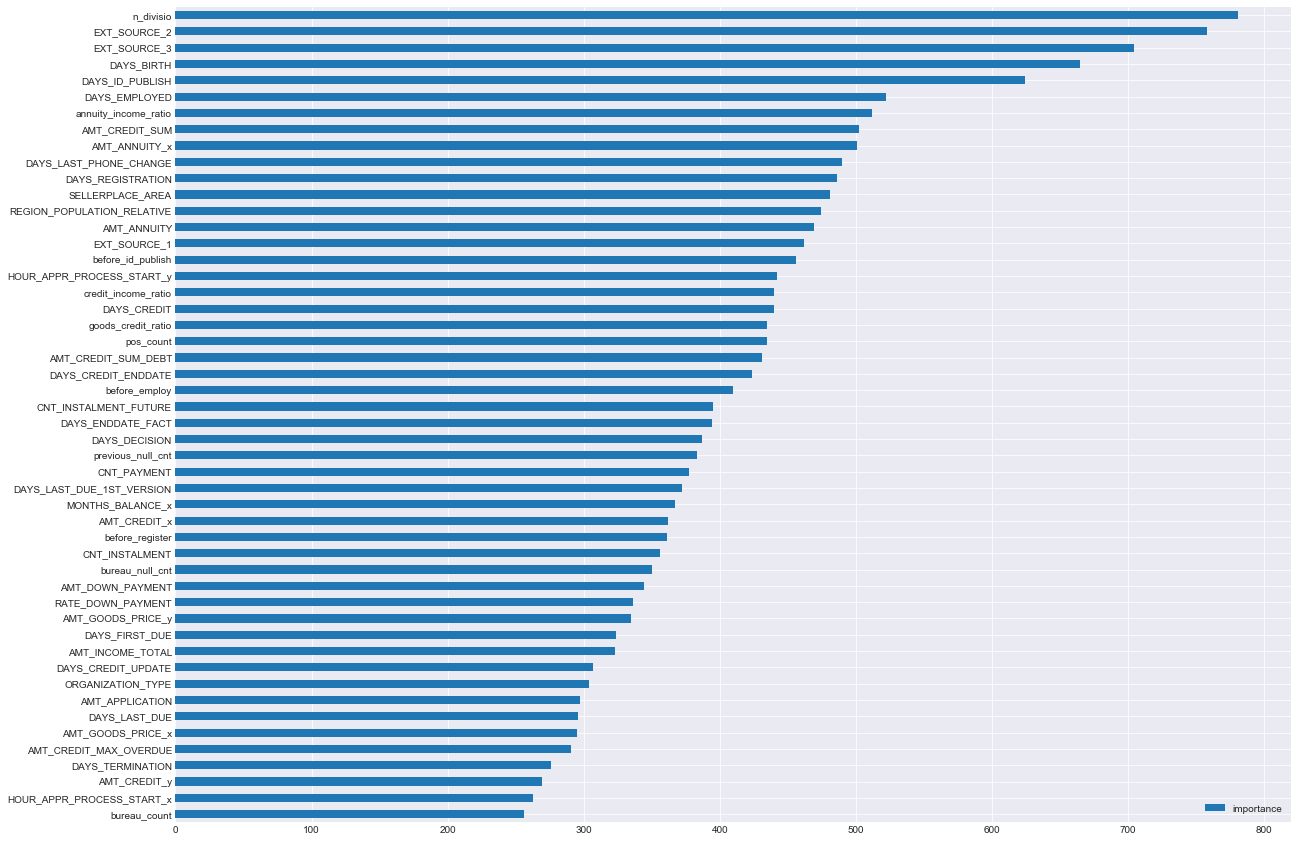

In [40]:
feat_df = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns).sort_values('importance')
feat_df[-50:].plot.barh(figsize=(20, 15))
plt.savefig(str(Path().home()/f'Dropbox/kaggle/{NAME}_feats.pdf'))
plt.show()

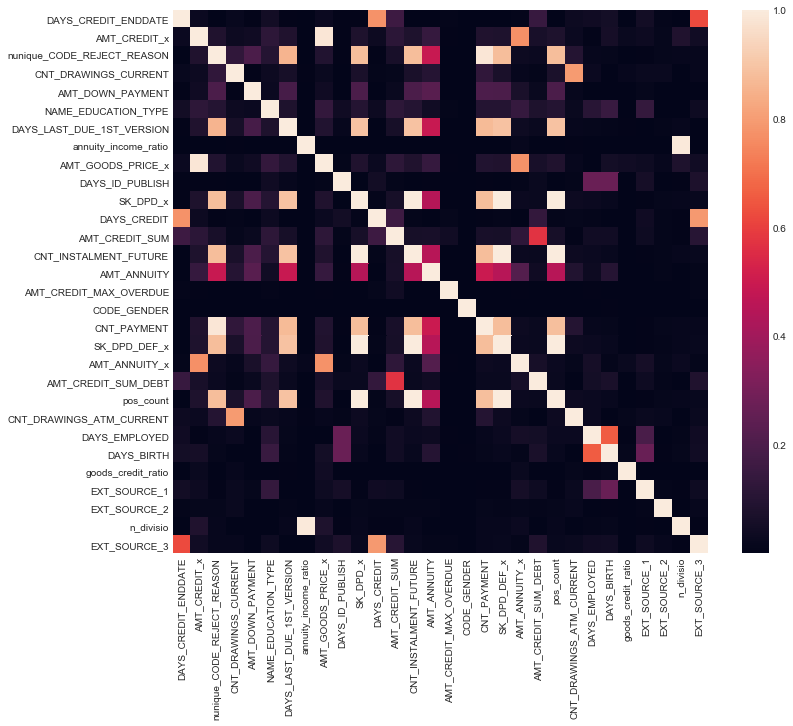

In [62]:
plt.figure(figsize=(12, 10))
sns.heatmap(abs(X_train[feat_df[-30:].index].corr()))
plt.show()